In [69]:
# import modules
from matrix_utils import targets_ykr_ids, get_travel_times_to_targets, add_min_travel_times_to_df, add_population_to_travel_times, calculate_cumulative_pop

import glob
import numpy as np
import pandas as pd
import geopandas as gpd

In [70]:
# read files
cinemas = gpd.read_file('data/cinemas.shp') # CHANGE TARGET SHP HERE
grid = gpd.read_file('data/MetropAccess_YKR_grid_EurefFIN.shp')
ykr_pop = pd.read_csv('data/ykr_pop_join.csv')

In [71]:
# set either small or large cinemas as targets
large_cinemas = cinemas.loc[cinemas['rooms'] > 2]
small_cinemas = cinemas.loc[cinemas['rooms'] <= 2]
targets = small_cinemas
print(targets[['name', 'rooms', 'seats', 'city']])

                      name  rooms  seats        city
0             Andorra Kino      1    180    Helsinki
1                BIO GRAND      1    184      Vantaa
2                BIO GRANI      1    137  Kauniainen
3   Espoon Kulttuurikeskus      1    300       Espoo
5                KANNUSALI      1    245       Espoo
6           KESÄKINO ENGEL      1     65    Helsinki
7               KINO ENGEL      2    170    Helsinki
8              KINO HELIOS      1    120    Helsinki
9                KINO K-13      1    150    Helsinki
10              KINO MYYRI      1    188      Vantaa
11            KINO TAPIOLA      1    194       Espoo
12              KINO TULIO      1     57    Helsinki
14   KORJAAMO KINO BIO REX      1    554    Helsinki
15     KORJAAMO KINO TÖÖLÖ      1    254    Helsinki
16                   MAXIM      2    236    Helsinki
18                   ORION      1    216    Helsinki
19                 RIVIERA      1     55    Helsinki
22      WHS Teatteri Union      1     85    He

In [72]:
# get ykr_ids for targets
target_ids = targets_ykr_ids(grid, targets)

CRS match: True
YKR ids: [5977006, 5879940, 5938497, 5968788, 5943907, 5977010, 5977010, 5913080, 5978644, 5903881, 5967147, 5963661, 5975374, 5965417, 5977009, 5978637, 5961889, 5972102]


In [73]:
# get traveltimes 2015 to targets 
folder15 = 'data/HelsinkiRegion_TravelTimeMatrix2015/'
ttimes15 = get_travel_times_to_targets(grid, target_ids, folder15)
ttimes15 = add_min_travel_times_to_df(ttimes15)
ttimes_pop_15 = add_population_to_travel_times(ttimes15, ykr_pop)
cum_pops_15 = calculate_cumulative_pop(ttimes_pop_15)

dropped 211 rows with na values


/Users/joose/Documents/hy/qmslup-poster/matrix_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ttimes['min_t'] = [int(value) for value in ttimes['min_t']]


In [74]:
ttimes15.head(2)

,YKR_ID,geometry,min_t,min_idx
0,5785640,"POLYGON ((382000.0001388059 6697750.000128186,...",92,pt_r_t_9
1,5785641,"POLYGON ((382250.00013875 6697750.000128181, 3...",95,pt_r_t_9


In [75]:
# get traveltimes 2018 to targets 
folder18 = 'data/HelsinkiTravelTimeMatrix2018/'
ttimes18 = get_travel_times_to_targets(grid, target_ids, folder18)
ttimes18 = add_min_travel_times_to_df(ttimes18)
ttimes_pop_18 = add_population_to_travel_times(ttimes18, ykr_pop)
cum_pops_18 = calculate_cumulative_pop(ttimes_pop_18)

dropped 127 rows with na values


/Users/joose/Documents/hy/qmslup-poster/matrix_utils.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ttimes['min_t'] = [int(value) for value in ttimes['min_t']]


In [76]:
# export 2018 travel times to SHP
ttimes18.to_file('results/tt_closest_small_18.shp')
ttimes_pop_18.to_file('results/tt_closest_small_pop_18.shp')
ttimes_pop_18.head(2)

,YKR_ID,geometry,min_t,min_idx,ASUKKAITA
0,5787548,"POLYGON ((382250.0001387566 6697500.000128225,...",100,pt_r_t_9,10
1,5791356,"POLYGON ((381000.0001390452 6697000.000128352,...",49,pt_r_t_9,13


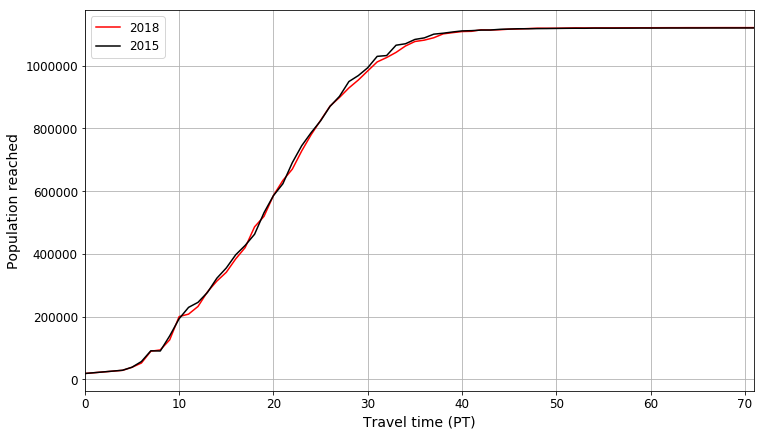

In [77]:
# PLOTS
import matplotlib.pyplot as plt

# prepare fig & ax for plotting
fig, ax = plt.subplots(figsize=(12,7))

# plot data
ax.plot(cum_pops_18['time'], cum_pops_18['cumpopulation'], c='red', label='2018')
ax.plot(cum_pops_15['time'], cum_pops_15['cumpopulation'], c='black', label='2015')

# set labels
ax.set(xlabel='Travel time (PT)', ylabel='Population reached')

# set axis & ticks
ax.set_xlim([0,71])
ax.grid()
# ticks every 10
x_ticks = np.arange(0, 71, 10)
#y_ticks = np.arange(0, 1110000, 100000)
ax.set_xticks(x_ticks)
#ax.set_yticks(y_ticks)

# set font size
plt.rcParams.update({'font.size': 12})
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

# add legend
ax.legend()

# save plot
fig.savefig('plots/pop_curve_test.png', dpi=150)
fig.savefig('plots/pop_curve_test.eps', format='eps', dpi=1000)

# show plot
plt.show()